# Data Mining Final Project - Notebook 2
### Datasets :
   > ### Wine Quality Dataset (White)
### Authors:
> ### Francisco Cunha, 76759
> ### João Amaral, 76460

The following notebook containts the development stages of the analysis and classifier modeling of a dataset, done for the final project of the course 44152 - Data Mining at University of Aveiro.
The project requested that the students selected two different datasets and apply common data mining techniques in order to extract patterns and predict behavior in the studied data (train classifiers). The students were required to freely select two datasets to develop the project, the only restriction being one of them had to contain some sort of categorical attributes. The first dataset chosen was the the Car Evaluation Dataset, containing categorical attributes, which is available at https://archive.ics.uci.edu/ml/datasets/Car+Evaluation. The second dataset chosen was the Wine Quality Dataset, available at https://archive.ics.uci.edu/ml/datasets/Wine+Quality. It contains two datasets one for red and other for white whine. The white wine one was then chosen.

The assignment of the project required the delivery of two notebooks, one containing only the data pre-processing and classifier modeling for both chosen datasets, while the second contains the complete processing including a cross validation scheme implementation and the justification for its selection.

This notebook corresponds to the second one, where the white wine dataset was chosen between the two processed in Notebook 1, and as such it is divided into 3 main stages:
    - Task A : Pre-processing stage
    - Task B : Training model stage
    - Task C : Model Evaluation stage
    
During the notebook the code used here for task A and B corresponds to the one presented in the first Notebook (Wine dataset), however here we describe each step made with proper justification for such decision. The last stage, Task C, corresponds to the implementation of a nested cross valiadation strategy in order to select the best classifier and to discover it's best hyperparameters.
 
In order to ease the reading of the notebook, both tasks were applied separately to each dataset and here displayed in two separate sections:

- [Dataset 2: White wine quality dataset](#Dataset-2-:-White-wine-quality-dataset)
    - [Task A: Wine Pre-processing](#Task-A:-Wine-Pre-processing)
    - [Task B: Wine Model Training](#Task-B:-Wine-Model-Training)
    - [Task C: Wine Model Evaluation](#Task-C:-Wine-Model-Evaluation)

# Dataset 2 : White wine quality dataset

## Task A: Wine Pre-processing 

- [Wine CSV's File Reading](#Wine-CSV's-File-Reading)
- [Wine Attributes and classes sample values](#Wine-Attributes-and-classes-sample-values)
- [Wine Class distribution visualization](#Wine-Class-distribution-visualization)
- [Wine Dataset detailed description](#Wine-Dataset-detailed-description)
- [Wine Attribute and class plotting examples](#Wine-Attribute-and-class-plotting-examples)
- [Wine Feature ranking](#Wine-Feature-ranking)
- [Wine feature scaling](#Wine-feature-scaling)
- [Wine dimension reduction](#Wine-dimension-reduction)
    - [Wine Principal Component Analysis (PCA)](#Wine-Principal-Component-Analysis-(PCA))
    - [Wine Kernel PCA](#Wine-Kernel-PCA)

### Wine CSV's File Reading

The first step of the pre-processing stage corresponds to the reading of the CSV file which contains the dataset to be processed. The Python Data Analysis Library (pandas) method read_csv() makes this possible by reading the dataset and creating a dataframe object containing the full attributes values and feature names, arranged in a two dimensional table. 
Before procceeding any further lets also make sure our dataset is complete, meaning no missing values. As we can see below, there are no missing values for any of the existing attributes. In case there were missing values an adequate replacement strategy would have to be here considered, such as invalidating the row containing the missing value or to replace the missing value with the mean of the attribute it corresponds to.

In [14]:
import pandas as pd
# Load dataframes from data set CSV files
dataset_white = pd.read_csv('./white_wine.csv') # numerical: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

dataset_white.isnull().any()

fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

### Wine Attributes and classes sample values

With the dataset now loaded we can get a glimpse of its data and internal organization by visualizing its first five intances.
The first eleven columns correspond to the features of the data (fixed acidity, volatile acidity,....,alcohol) while the last one, "quality", corresponds to a metric that represents how good the wine, composed by the previous attributes, was rated on a scale between 1 to 10.

In [9]:
dataset_white.head() # shows only the first 5 instances on the data set

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Wine Class distribution visualization

Now that we know how the data is organized we can start to plot it in graphs to better grasp some of its inner properties such as class distribution. To the simple plotting and data analysis techniques of the dataset, data scientists give the name of __Univariate analysis__. It corresponds to the simplest form of data analysis or visualization where one is only concerned with analyzing one data attribute or variable and visualizing the same (in one dimension). Lest consider the class attribute and visualize its distribution:

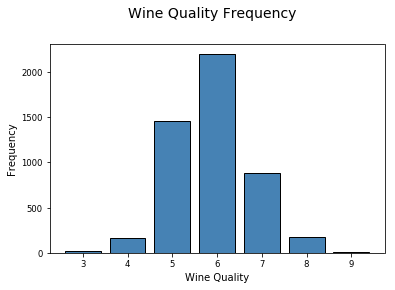

In [25]:
%matplotlib inline 
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = (6, 4))
title = fig.suptitle("Wine Quality Frequency", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Wine Quality")
ax.set_ylabel("Frequency") 
white_quality = dataset_white['quality'].value_counts()
white_quality = (list(white_quality.index), list(white_quality.values))
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(white_quality[0], white_quality[1], color='steelblue', 
        edgecolor='black', linewidth=1)

### Wine Dataset detailed description

Now lets apply the same technique to the whole dataset attributes in order to get a better understanding of the data distribution of these features. The describe() method of a dataframe can also give us some more detailed information for each of the datset attributes: the mean attribute value, the standard deviation, its minimum and maximum values and 25, 50 and 75 percentiles. The histograms below present helps visualize the value distribution of each attribute. From its analysis we can already observe some skewing in their distribution.

Dataset description


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


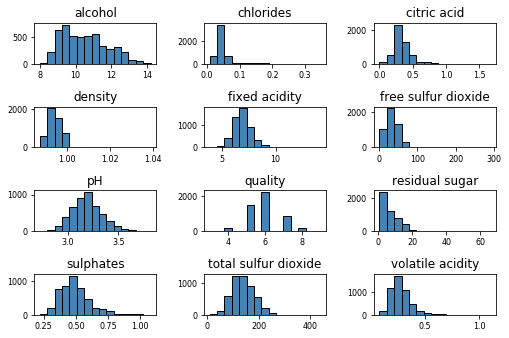

In [31]:
print("Dataset description")
display(dataset_white.describe())

dataset_white.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

### Correlation matrix heatmap

In order to further study our dataset it is important to discover if there are any feature dependencies between features, usually designed as feature correlation, and which ones might influence the quality rating the most. Here we introduce the concept of  __Multivariate Analysis__ which involves the analysis of multiple data dimensions (attributes), referring to 2 or more. More than just analysing the attribute distributions it extends this analysis to discover possible existing relationships between attributes, as well as other patterns and correlations.

One of the best methods used to study this behavior is to compute and visualize the correlation matrix of the dataset. A scatterplot and a heatmap plot can be seen in the figures below, where pair-wise attributes properties are analysed together. From the analysis of the scatterplot it is possible to conclude that for some features the distribution appears to have a negative skew while for others the distribution is mostly linear, leading to the conclusion that there is, after all, some dependencies between pairs of features. 

On the same page, from the analysis of the heatmap it is clearly visible the strong correlations amongst features. For example the attribute pair "residual sugar" X "density" and "free sulfur dioxide" X "total sulfur dioxide" have higher dependencies (correlation) between them (indicated by the higher positive values of the heatmap). Simply put, this means that if one of those values where to increase, its pair attribute would also increase. It can also show us the inverse property, displayed in the squares with negative values, representing an inverse co-relationship. Meaning that the more one of those values increases, the more its pair decreases. The other remaining squares in the heatmap, with values close to zero, represent a lack of dependency between the features.

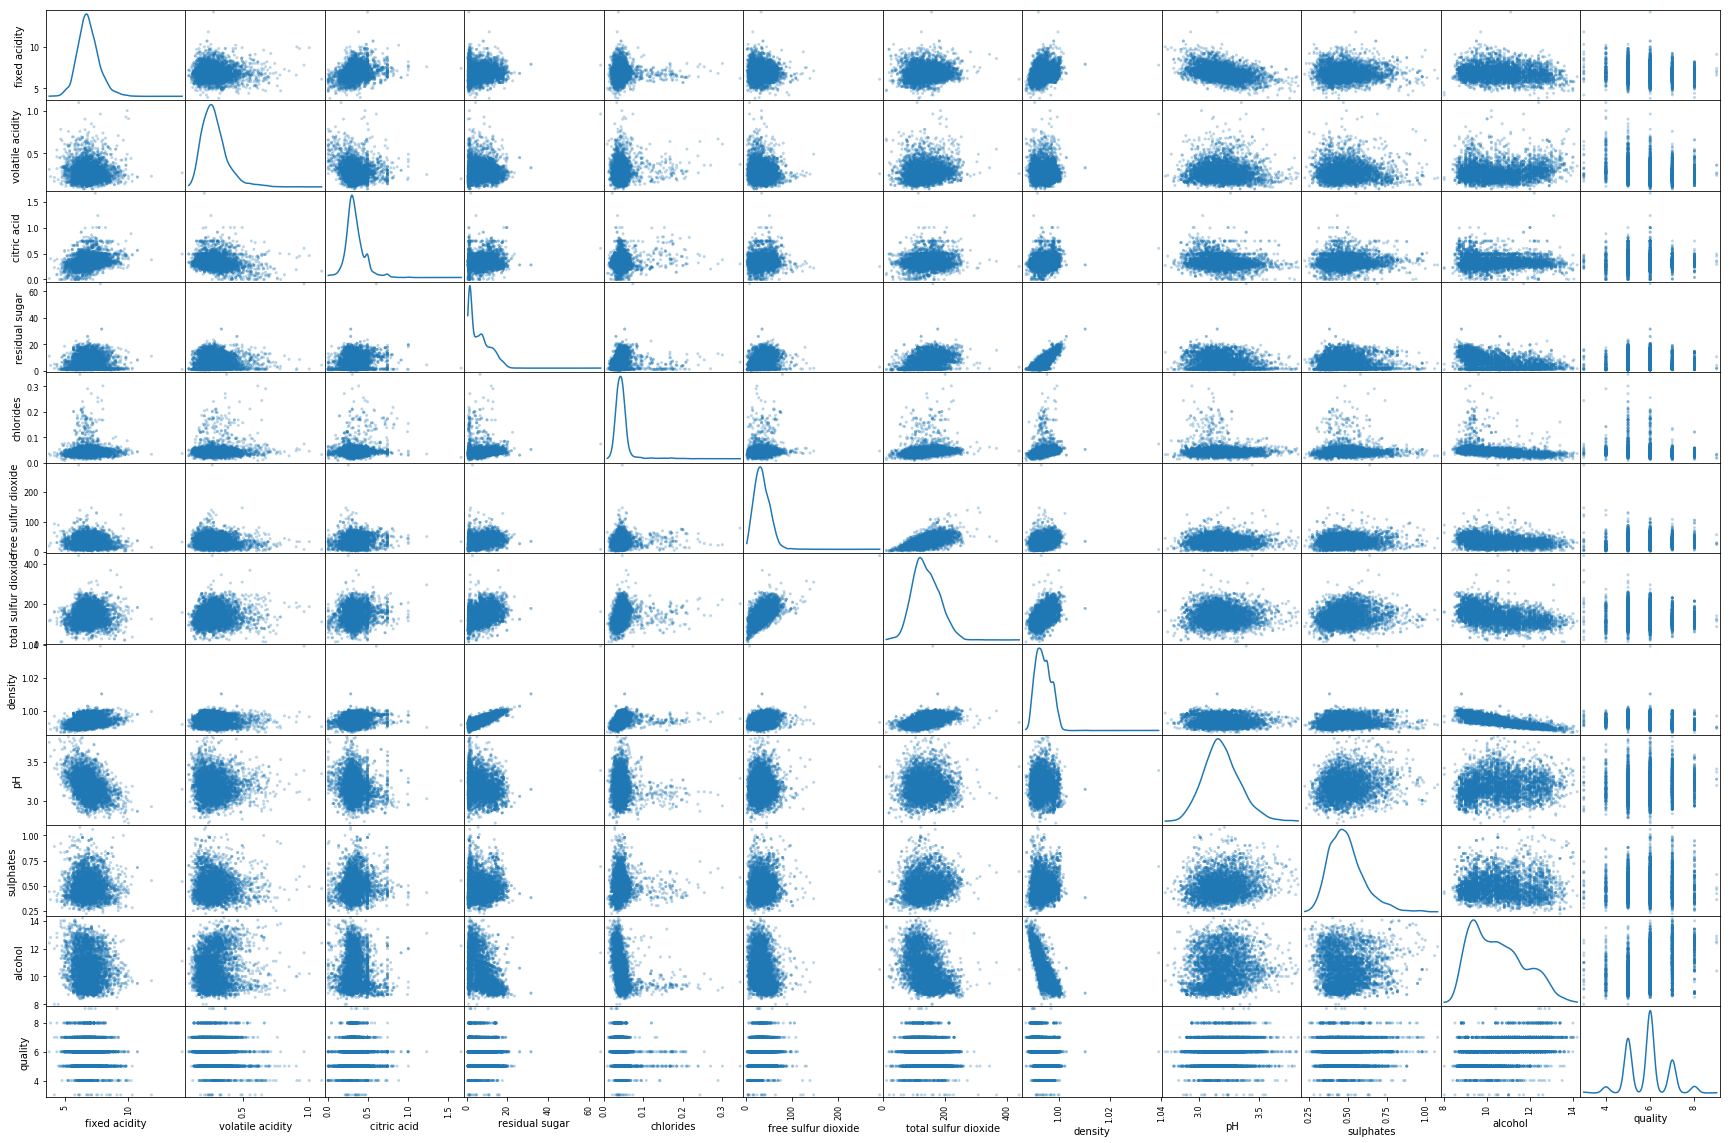

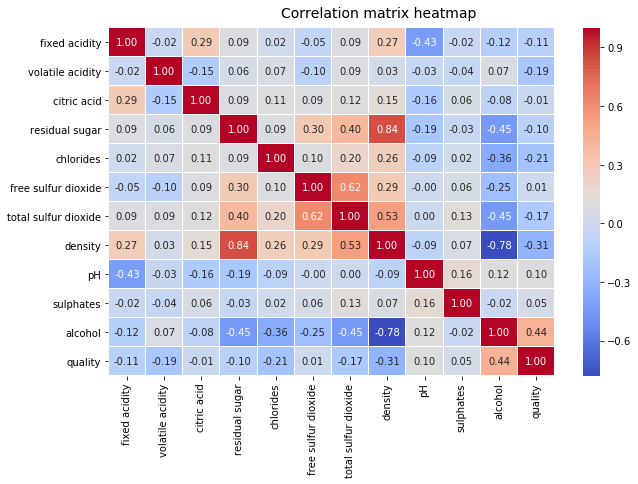

In [32]:
# Scatterplot of dataset
pd.plotting.scatter_matrix(dataset_white, alpha = 0.3, figsize = (30,20), diagonal = 'kde');

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = dataset_white.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation matrix heatmap', fontsize=14)

We can go further an comprove the accuracy of the correlations presented in the heatmap by studying some attribute pair. Let's then consider the pair above mentioned, free sulfur dioxide" X "total sulfur dioxide, which have positive correlation, and the pair "density" X "alcohol" with negative correlation. In the following figure there is present both the regression plot of the two features and their respective distribution plots.

In the first figure the pair "density" X "alcohol" is displayed and it confirms that, being a negative value correlation pair in the heatmap (with value -0.78), as the values of alcohol increase, it's overall density decreases. The opposite occurrence is shown in the other figure where as the free sulfur dioxide values increases, the total sulfur dioxide increased aswell.

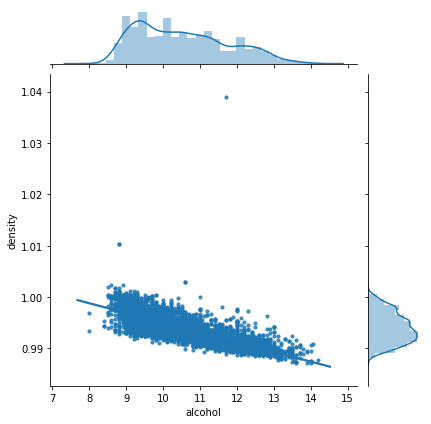

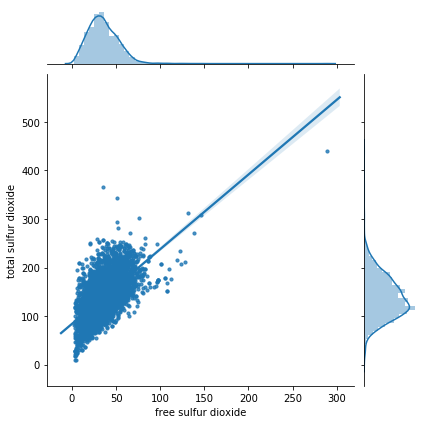

In [39]:
# We consider a new dataframe only for alcohol and density attributes
alcohol_density = dataset_white[['alcohol', 'density']] 
#Initialize a joint-grid with the dataframe, using seaborn library
gridA = sns.JointGrid(x="alcohol", y="density", data=alcohol_density, height=6) #Draw the regression plot
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10})
gridA = gridA.plot_marginals(sns.distplot) # Draw the distribution plot on the same figure

fso_tso = dataset_white[['free sulfur dioxide', 'total sulfur dioxide']]
gridB = sns.JointGrid(x="free sulfur dioxide", y="total sulfur dioxide", data=fso_tso, height=6)
gridB = gridB.plot_joint(sns.regplot, scatter_kws={"s": 10})
gridB = gridB.plot_marginals(sns.distplot)

### Wine Feature ranking

One important step in data pre-processing is the identification and selection of the best features that are going to be used to solve the classification problem. Usually there are features in a dataset that are not relevant or redundant for the classifier and that can even, in fact, decrease the accuracy of the model. As such, the feature selection methods aid us in this mission of creating the accurate predictive model by choosing features that will give us a simillar or even better accuracy whilst requiring less data. One misconception that usually exists is that more attributes or column data has a direct correlation with the accuracy obtained, which is wrong. In fact, fewer attributes is sometimes the most desirable in a dataset, since it decreases the complexity of the model, making it simpler to analize and understand.

For our problem, we have considered two feature selection techniques: the __Shapiro-Wilk__ ranking algorithm and a __chi squared statistical test__ to select the 5 best features out of the existing 11.

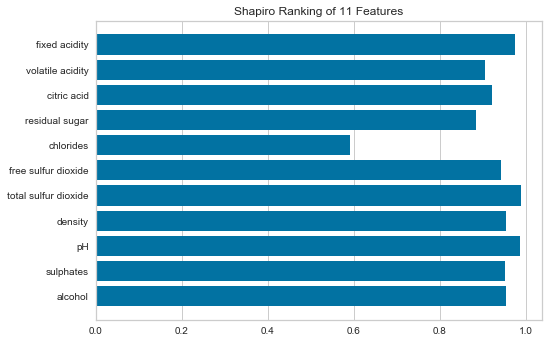

In [144]:
from yellowbrick.features import Rank1D

attributes_wine = array[:,0:11]
labels_wine = array[:,11]
features = list(dataset_white.columns[0:11])

#Instantiate the 1D visualizer with the Sharpiro ranking algorithm
visualizer = Rank1D(features=features, algorithm='shapiro')
visualizer.fit(attributes_wine, labels_wine)	# Fit the data to the visualizer
visualizer.transform(attributes_wine)	# Transform the data
visualizer.poof()

Resulting scores:
[  7.922e+00   1.262e+01   8.511e-01   5.012e+02   2.529e+00   9.477e+02
   3.358e+03   5.065e-03   4.287e-01   5.792e-01   1.551e+02]

Resulting 5 best features:


[('total sulfur dioxide', 3358.2984332694855),
 ('free sulfur dioxide', 947.71284503899517),
 ('residual sugar', 501.23522376494446),
 ('alcohol', 155.07823387942128),
 ('volatile acidity', 12.622636002587354)]

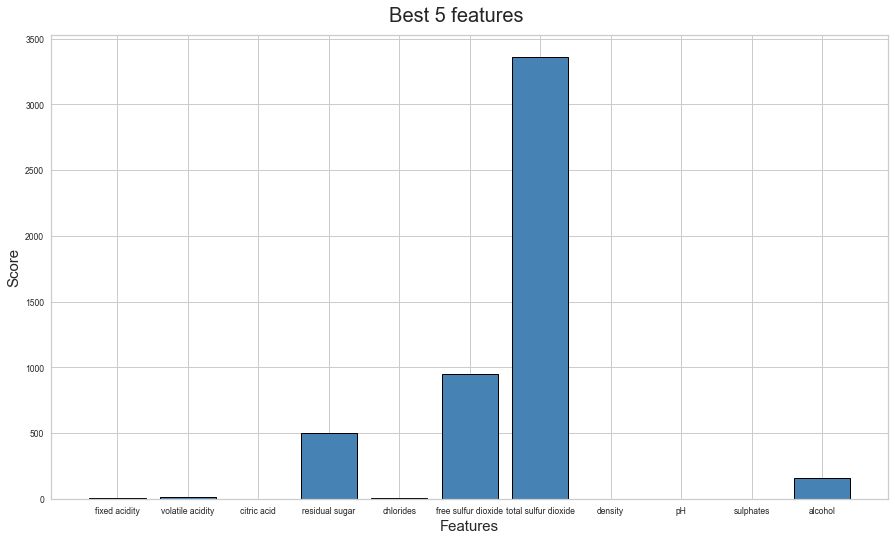

In [148]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np

array = dataset_white.values
features = dataset_white.columns[0:11]
X = array[:,0:11]
Y = array[:,11]
# feature extraction
n_best_features = 5
test = SelectKBest(score_func=chi2, k=n_best_features)
fit = test.fit(X, Y)
# summarize scores
np.set_printoptions(precision=3)

# generalized code for obtaining any n_best_features
print("Resulting scores:\n{}".format(fit.scores_))
result = dict(zip(list(features),fit.scores_))
print("\nResulting {} best features:".format(n_best_features))
display(sorted(result.items(), key=lambda kv: kv[1], reverse=True)[0:n_best_features])

# scores plot
fig = plt.figure(figsize = (15, 8))
title = fig.suptitle("Best " + str(n_best_features) + " features", fontsize=20)
fig.subplots_adjust(top=0.93, wspace=0.1)
ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Features", fontsize=15)
ax.set_ylabel("Score", fontsize=15) 
scores = fit.scores_ 
d = (list(features),list(scores))
ax.tick_params(axis='both', which='major', labelsize=8.5)
bar = ax.bar(d[0], d[1], color='steelblue', edgecolor='black', linewidth=1)

The Shapiro-Wilk method accesses the normality of the distribution of instances with respect to the feature and attributes it a score in the range [0,1]. From its application we can conclude that all the features have a simillar score, except for the chlorides which as the lowest score differing from the rest by approximately 0.3 units, which could be considered for removal.

The chi squared method however shows a different set of results, assigning the best score to "total sulfur dioxide", followed by "free sulfur dioxide", "residual sugar" and "alcohol". For this case we obtain, however, a great diversity between the scores of the features. These values also greately diverge from the ones obtained in the Shapiro-Wilk approach which could not allow the establishment of a correlation pattern. As such we decided that these results obtained were inconclusive and decided to keep the original features of the dataset to train our classifiers. To solve this problem and obtain a more accurate scoring result we would need to carefully dissect each ranking method, investigate further and possibly implement and compare the results to other ranking methods such as Recursive Feature Elimination or Feature Importance scores used in the ensemble classificators, which was not possible due to time constraints. 


The whitepaper "Selection of important features and predicting wine quality using machine learning techniques", discovered in a later stage of the development of the project, does an extensive research on the best feature selection for both SVM and neural networks and could be a useful resource for posterior analysis. The authors conclude that fixed  acidity,  volatile  acidity,  residual  sugar,  free  sulfur  dioxide,  density,  pH, sulphates and alcohol are the best parameters for the white wine dataset.

source: https://www.sciencedirect.com/science/article/pii/S1877050917328053

### Wine feature scaling

Feature scaling corresponds to an often necessary step to standardize the range of features of the dataset. It is done because usually the range of values of the original data varies widely and, due to this, some machine learning algorithms will not work properly without this extra processing step. Some classification algorithm require algebric calculations, usually distances between points using the Euclidean distance. As such, if the values used in the operations are not normalized, the feature containing the broad range of values will heavily influence its the operation outcome, which is not desired. All features should then be normalized so that each feature contributes approximately proportionately to the final distance calculated.
For our solution, we used the already developed scaling operator in sklean StandardScaler() that normalizes all the attribute values accordingly.

In [147]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(attributes_wine)
X_white_train_std = sc.transform(attributes_wine)

### Wine dimension reduction

#### Wine Principal Component Analysis (PCA)

In [42]:
X_wine_train, X_wine_test, Y_wine_train, Y_wine_test = \
    train_test_split(attributes_wine, labels_wine, test_size=0.3, random_state=0)

In [43]:
sc = StandardScaler()
X_wine_train_std = sc.fit_transform(X_wine_train)
X_wine_test_std = sc.transform(X_wine_test)

In [44]:
pca_wine = PCA()
X_wine_train_pca = pca_wine.fit_transform(X_wine_train_std)

pca_wine.explained_variance_ratio_

# Aqui podes ver o peso dos principais componentes ordenados por ordem decrescente do conjunto
# Como podes ver, nao há pelo menos dois PC's em que a soma delas seja por exemplo 90%, pelo que se se diminuir
# para 2 componentes vai ser 0.2968005 + 0.14152228 = 43.8 %
# Desta forma, o PCA nao vai funcionar muito bem como podes reparar em baixo nos 2 graficos

array([ 0.2968005 ,  0.14152228,  0.11156618,  0.09484842,  0.0869572 ,
        0.08356054,  0.06607424,  0.05441625,  0.03669958,  0.02627999,
        0.00127482])

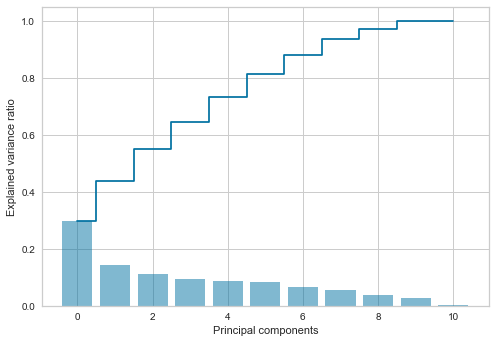

In [45]:
plt.bar(range(11), pca_wine.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(11), np.cumsum(pca_wine.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [46]:
# Only two components for illustration
pca_wine = PCA(n_components=5)
X_wine_train_pca = pca_wine.fit_transform(X_wine_train_std)
print(pca_wine)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


In [47]:
X_wine_test_pca = pca_wine.transform(X_wine_test_std)

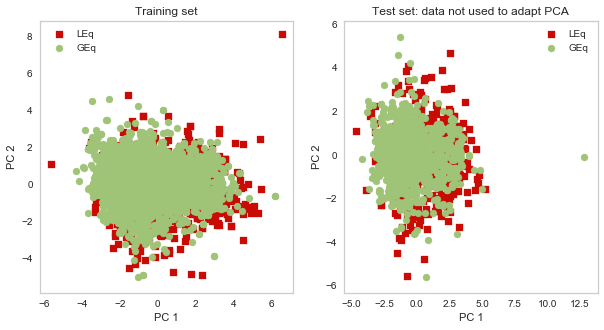

In [48]:
# os valores de Y variam entre 0 e 10

plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes = axes.ravel()   
ax = axes[0]
ax.figure
inx=(Y_wine_train <= 5) # 1, 2, 3, 4, 5
inx=inx.ravel()
ax.scatter(X_wine_train_pca[inx,0],X_wine_train_pca[inx,1],marker='s',color='r',label='LEq') # Less or Equal  

inx=(Y_wine_train >= 6) # 6, 7, 8, 9, 10
inx=inx.ravel()
ax.scatter(X_wine_train_pca[inx,0],X_wine_train_pca[inx,1],marker='o',color='g',label='GEq') # Great or Equal
ax.set_title("Training set")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend()
ax.grid()

ax = axes[1]
ax.figure
inx=(Y_wine_test <= 5) # 1, 2, 3, 4, 5
inx=inx.ravel()
ax.scatter(X_wine_test_pca[inx,0],X_wine_test_pca[inx,1],marker='s',color='r',label='LEq')  
inx=(Y_wine_test >= 6) # 6, 7, 8, 9, 10
inx=inx.ravel()
ax.scatter(X_wine_test_pca[inx,0],X_wine_test_pca[inx,1],marker='o',color='g',label='GEq')
    
ax.set_title("Test set: data not used to adapt PCA")    

ax.legend() 
ax.grid()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

#### Wine Kernel PCA

In [49]:
kpca_wine = KernelPCA(n_components = 5, kernel= 'rbf', gamma=15)
X_skpca_wine = kpca_wine.fit_transform(X_wine_train_std)
print(X_skpca_wine.shape)

(3428, 5)


In [50]:
X_wine_test_kpca = kpca_wine.transform(X_wine_test_std)
print(X_wine_test_pca.shape)

(1470, 5)


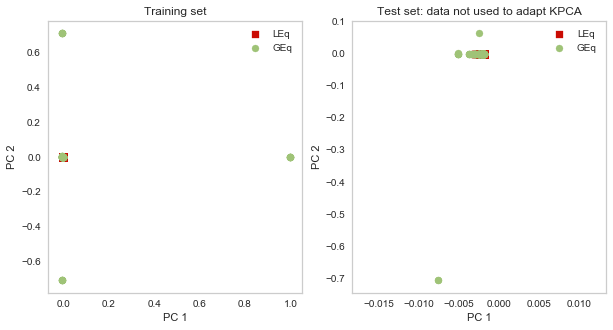

In [51]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes = axes.ravel()   
ax = axes[0]
ax.figure
inx=(Y_wine_train <= 5) # 1, 2, 3, 4, 5
inx=inx.ravel()
ax.scatter(X_skpca_wine[inx,0],X_skpca_wine[inx,1],marker='s',color='r',label='LEq') # Less or Equal  

inx=(Y_wine_train >= 6) # 6, 7, 8, 9, 10 
inx=inx.ravel()
ax.scatter(X_skpca_wine[inx,0],X_skpca_wine[inx,1],marker='o',color='g',label='GEq') # Great or Equal
ax.set_title("Training set")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.legend()
ax.grid()

ax = axes[1]
ax.figure
inx=(Y_wine_test <= 5) # 1, 2, 3, 4, 5
inx=inx.ravel()
ax.scatter(X_wine_test_kpca[inx,0],X_wine_test_kpca[inx,1],marker='s',color='r',label='LEq')  
inx=(Y_wine_test >= 6) # 6, 7, 8, 9, 10 
inx=inx.ravel()
ax.scatter(X_wine_test_kpca[inx,0],X_wine_test_kpca[inx,1],marker='o',color='g',label='GEq')
    
ax.set_title("Test set: data not used to adapt KPCA")    

ax.legend() 
ax.grid()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

## Task B: Wine Model Training

- [Wine Dataset partition](#Wine-Dataset-partition)
- [Wine SVM classfiers](#Wine-SVM-classifiers)
    - [Wine SVM linear kernel](#Wine-SVM-linear-kernel)
    - [Wine SVM polynomial kernel](#Wine-SVM-polynomial-kernel)
    - [Wine SVM rbf kernel](#Wine-SVM-rbf-kernel)
    - [Wine SVM sigmoid kernel](#Wine-SVM-sigmoid-kernel)
- [Wine Multi-layer Perceptron](#Wine-Multi-layer-Perceptron)
- [Wine K-Nearest Neighbors](#Wine-K-Nearest-Neighbors)
- [Wine Decision tree](#Wine-Decision-tree)
- [Wine Random forest](#Wine-Random-forest)
- [Wine Gradient boosting](#Wine-Gradient-boosting)
- [Wine Preliminary results](#Wine-Preliminary-results)

From the classifers models trained in the first notebook we obtained some preliminary results that we used to select which classifiers were best suited for this dataset. As such we decided to use __SVM with RBF kernel__ and __Multilayer Perceptron__ as the models used for the final training, validation and hyperparameter tuning.

| Classifier | Accuracy results |
| --- | --- | 
|SVM Linear | 0.527210884354 |
|SVM Polynomial	| 0.500680272109 |
|SVM RBF | 0.554421768707 |
|SVM Sigmoid | 0.444897959184 |
|MLP | 0.560544217687 |
|KNN | 0.534693877551 |
|Decision tree | 0.578911564626 |
|Random forest | 0.534013605442 |
|Gradient boosting | 0.549659863946 |

### Wine Dataset partition

#### Holdout Validation

In [ ]:
X_white_train, X_white_test, Y_white_train, Y_white_test = \
    train_test_split(X_white_train_std, labels_wine, test_size = test_frac)

#### Nested Cross Validation

### Wine SVM classfiers

#### Wine SVM linear kernel

In [53]:
svc = SVC(kernel='linear', C=1.0)
svc.fit(X_white_train, Y_white_train)
predictions = svc.predict(X_white_test)
svm_lin_score = accuracy_score(Y_white_test, predictions)
print('Linear SVM Accuracy: {:.2%}'.format(svm_lin_score))

Linear SVM Accuracy: 52.72%


#### Wine SVM polynomial kernel

In [54]:
svc = SVC(kernel='poly', degree=2, C=1.0)
svc.fit(X_white_train, Y_white_train)
predictions = svc.predict(X_white_test)
svm_poly_score = accuracy_score(Y_white_test, predictions)
print('Polynomial SVM Accuracy: {:.2%}'.format(svm_poly_score))

Polynomial SVM Accuracy: 50.07%


#### Wine SVM rbf kernel

In [55]:
svc = SVC(kernel='rbf', C=1.0)
svc.fit(X_white_train, Y_white_train)
predictions = svc.predict(X_white_test)
svm_rbf_score = accuracy_score(Y_white_test, predictions)
print('RBF SVM Accuracy: {:.2%}'.format(svm_rbf_score))

RBF SVM Accuracy: 55.44%


#### Wine SVM sigmoid kernel

In [56]:
svc = SVC(kernel='sigmoid', C=1.0)
svc.fit(X_white_train, Y_white_train)
predictions = svc.predict(X_white_test)
svm_sigm_score = accuracy_score(Y_white_test, predictions)
print('Sigmoid SVM Accuracy: {:.2%}'.format(svm_sigm_score))

Sigmoid SVM Accuracy: 44.49%


### Wine Multi-layer Perceptron

In [57]:
mlp = MLPClassifier(activation='tanh', hidden_layer_sizes=(10,5),alpha=0.01, max_iter=5000)
mlp.fit(X_white_train, Y_white_train)
predictions = mlp.predict(X_white_test)
mlp_score = accuracy_score(Y_white_test, predictions)
print('MLP Accuracy: {:.2%}'.format(mlp_score))

MLP Accuracy: 56.05%


### Wine K-Nearest Neighbors

In [58]:
knn = KNeighborsClassifier()
knn.fit(X_white_train, Y_white_train)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2, weights='uniform')
predictions = knn.predict(X_white_test)
knn_score = accuracy_score(Y_white_test, predictions)
print("KNN Accuracy: {:.2%}".format(knn_score))

KNN Accuracy: 53.47%


### Wine Decision tree

In [59]:
from sklearn import tree

tree = tree.DecisionTreeClassifier(criterion='gini')
tree.fit(X_white_train,Y_white_train)
tree_score = tree.score(X_white_test,Y_white_test)
print('Decision Tree Accuracy: {:.2%}'.format(tree_score))

Decision Tree Accuracy: 57.89%


### Wine Random forest

In [60]:
forest = RandomForestClassifier(max_depth=3, min_samples_split=5,n_estimators=10, max_features='log2', oob_score=False)	
forest.fit(X_white_train,Y_white_train)
rf_score = forest.score(X_white_test,Y_white_test)
print('Random Forest Accuracy: {:.2%}'.format(rf_score))

Random Forest Accuracy: 53.40%


### Wine Gradient boosting

In [61]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
clf.fit(X_white_train, Y_white_train)
gb_score = clf.score(X_white_test, Y_white_test)  
print('Gradient Boosting Accuracy: {:.2%}'.format(gb_score))

Gradient Boosting Accuracy: 54.97%


### Wine Preliminary results

In [62]:
data = [['Classifier','Accuracy results'],
        ['SVM Linear', svm_lin_score],
        ['SVM Polynomial',svm_poly_score],
        ['SVM RBF',svm_rbf_score],
        ['SVM Sigmoid',svm_sigm_score],
        ['MLP', mlp_score],
        ['KNN', knn_score,],
        ['Decision tree', tree_score],
        ['Random forest', rf_score],
        ['Gradient boosting', gb_score]]


display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
)))

Classifier,Accuracy results
SVM Linear,0.527210884354
SVM Polynomial,0.500680272109
SVM RBF,0.554421768707
SVM Sigmoid,0.444897959184
MLP,0.560544217687
KNN,0.534693877551
Decision tree,0.578911564626
Random forest,0.534013605442
Gradient boosting,0.549659863946


## Task C: Model evaluation